In [28]:
from __future__ import absolute_import

import cv2
import numpy as np
import os
import os.path as osp
import pdb
from matplotlib import pyplot as plt

def unit16b2uint8(img):
    if img.dtype == 'uint8':
        return img
    elif img.dtype == 'uint16':
        return img.astype(np.uint8)
    else:
        raise TypeError('No such of img transfer type: {} for img'.format(img.dtype))

def img_standardization(img):
    img = unit16b2uint8(img)
    if len(img.shape) == 2:
        img = np.expand_dims(img, 2)
        img = np.tile(img, (1, 1, 3))
        return img
    elif len(img.shape) == 3:
        return img
    else:
        raise TypeError('The Depth of image large than 3 \n')
    
def load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            #pdb.set_trace()
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            images.append(img)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def new_load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            img = bgr_to_gray(img)
            img = img.astype('float32')
            images.append(img / 255)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def bgr_to_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img 


class BinaryThresholding:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        gray = bgr_to_gray(img)
        (_, binary_mask) = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY)
        binary_mask = cv2.medianBlur(binary_mask, 5)
        connectivity = 4
        _, label_img, _, _ = cv2.connectedComponentsWithStats(binary_mask , connectivity , cv2.CV_32S)
        return label_img
    

if __name__ == "__main__":
    segmentor = BinaryThresholding(threshold=110)
    x_train_path = './dataset1/train/'
    y_train_path = './dataset1/train_GT/SEG/'
    test_path = './dataset1/test/'
    result_path = './dataset1/test_RESRES'
    if not osp.exists(result_path):
        os.mkdir(result_path)
    x_train_list = sorted([osp.join(x_train_path, x) for x in os.listdir(x_train_path) if x.find('.tif') != -1])
    y_train_list = sorted([osp.join(y_train_path, y) for y in os.listdir(y_train_path) if y.find('.tif') != -1])
    test_list = sorted([osp.join(test_path, test) for test in os.listdir(test_path) if test.find('.tif') != -1])
    X_train = load_images(x_train_list)
    Y_train = load_images(y_train_list)
    images = load_images(test_list)
    for index, image in enumerate(images):
        label_img = segmentor(image)
        cv2.imwrite(osp.join(result_path, 'mask{:0>3d}.tif'.format(index)), label_img.astype(np.uint16))
        
    print("done")
    print(len(X_train), len(Y_train), len(images))

done
175 175 33


In [88]:
import numpy as np 
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend

In [191]:
#backend.set_image_data_format('channels_first')

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = keras.Input(shape = input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    def iou(y_pred, y_true):
        y_pred = tf.cast((y_pred > 0), dtype=tf.float32)
        i = tf.reduce_sum(y_true * y_pred)
        u = tf.reduce_sum(y_true + y_pred)
        return (i / u).item()if u != 0 else u.item()
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',iou])
    
    model.summary()


    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [192]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold

def useSVM():
    param_grid = {'C': [1,10, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X, Y)
    print(clf.score(X, Y))
    #KF = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    #for train, test in KF.split(X, Y):
    return 0


In [193]:
X = np.array(X_train)
Y = np.array(Y_train)
X = X.reshape(175*628*628,3)
Y = Y[:,:,:,0].reshape(-1,1)
'''
print(X.shape)
print(Y.shape)
print(X)
print(Y)
print(X_train)
print(Y_train)
'''

'\nprint(X.shape)\nprint(Y.shape)\nprint(X)\nprint(Y)\nprint(X_train)\nprint(Y_train)\n'

In [194]:
#useSVM()
dir('Tensor')

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [195]:
def useKMeans():
    #img = cv2.imread('./dataset1/test/t000.tif',-1)
    for i in range(33):
        img = images[i]
        #print(np.array(img).shape)
        #print(np.array(images).shape)
        b, g, r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img_flat = np.array(img).reshape((img.shape[0] * img.shape[1], 3))
        img_flat = np.float32(img_flat)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 20, 0.5)
        flags = cv2.KMEANS_RANDOM_CENTERS
        K = 2
        compactness, labels, centers = cv2.kmeans(img_flat, K, None, criteria, 10, flags)
        
        img_output = labels.reshape((img.shape[0], img.shape[1]))
        plt.imshow(img_output)
        plt.show
        cv2.imwrite(osp.join('./dataset1/res1', 'mask{:0>3d}.tif'.format(i)), img_output.astype(np.uint16))
        
def makezip():
    import zipfile
    source = './dataset1/res1'
    target_name = './dataset1/dataset1.zip'
    fzip = zipfile.ZipFile(target_name, 'w', zipfile.ZIP_DEFLATED)
    flist = os.listdir(source)
    #basename = os.path.basename(source)
    for name in flist:
        fpath = os.path.join(source, name)
        #arcname = os.path.join(basename, name)
        #写入要压缩文件，并添加归档文件名称
        fzip.write(fpath)
    #关闭
    fzip.close()


In [196]:
#useKMeans()
#makezip()

In [197]:
model = unet()

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [84]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
 
        for i in range(num_class):
            new_mask[mask == i,i] = 1 #将平面的mask的每类，都单独变成一层，
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img_standardization(img)
        mask = img_standardization(mask)
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

def train_Generator(batch_size,train_path, mask_path, image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False, num_class = 2,save_to_dir = None,target_size = (256, 256),seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    '''
    generated_images = ImageDataGenerator(
        featurewise_center = True,
        samplewise_center = False,
        featurewise_std_normalization = True,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 0,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = False)
    '''
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        #img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
    print(img.shape)
    print(mask.shape)

        
def testGenerator(test_path,target_size = (256,256),flag_multi_class = True,as_gray = False):
    files = os.listdir(test_path)
    for file in files:
        img = cv2.imread(os.path.join(test_path,file),-1)
        img = img / 255
        img = cv2.resize(img,target_size)
        img = np.reshape(img,img.shape + (1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,) + img.shape)
        yield img

def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.tif"%image_prefix))
    
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):#enumerate是枚举，输出[(0,item0),(1,item1),(2,item2)]
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = cv2.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),-1)
#重新在mask_path文件夹下搜索带有mask字符的图片（标签图片）
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)#转换成array
    return image_arr,mask_arr

In [87]:
aug_path = './dataset1/aug1'
if not osp.exists(aug_path):
    os.mkdir(aug_path)
    
res1_path = './dataset1/res1'
if not osp.exists(res1_path):
    os.mkdir(res1_path)
    
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='nearest')
myGene = train_Generator(5,'./dataset1','./dataset1/train_GT','train','SEG',data_gen_args,save_to_dir = aug_path)
print(next(myGene)[0].shape)
print(next(myGene)[1].shape)
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,batch_size = 16, epochs=10, callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, 
                    verbose=0, mode='auto', baseline=None, restore_best_weights=False))
#model.fit(X_train, Y_train, batch_size = 32,epochs=1,callbacks=[model_checkpoint])

Found 175 images belonging to 1 classes.
Found 175 images belonging to 1 classes.
(5, 256, 256, 3)
(5, 256, 256, 3)
  ...
    to  
  ['...']
Train for 300 steps
Epoch 1/3
  1/300 [..............................] - ETA: 9s

InvalidArgumentError:  Incompatible shapes: [5,10,256,256] vs. [5,3,256,256]
	 [[node loss/conv2d_39_loss/mul (defined at <ipython-input-86-c4a5ed67d58b>:21) ]] [Op:__inference_distributed_function_6267]

Function call stack:
distributed_function


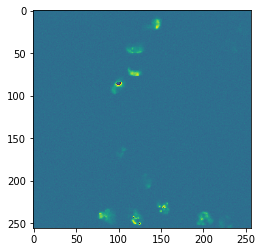

33


In [12]:


testGene = testGenerator(r"./dataset1/test")
image_path = './dataset1/test/'
image_list = sorted([osp.join(image_path, image) for image in os.listdir(image_path)])
n_images = new_load_images(image_list)
N = len(n_images)
n_images = np.array(n_images)
n_images = n_images.reshape(N, 628, 628, 1)
test = np.empty((N, 256, 256))
shape = (256, 256)
for i in range(N):
    test[i] = cv2.resize(n_images[i], shape)
plt.imshow(test[0])
plt.show()
print(N)


In [15]:
test = test.reshape(N, 256, 256, 1)
results = model.predict_generator(test,11,verbose=1)
for index,item in enumerate(results):
    cv2.imwrite(osp.join(res1_path, 'mask{:0>3d}.tif'.format(index)), label_img.astype(np.uint16))


33/33 [==============================] - 11s 347ms/sample


NameError: name 'result' is not defined

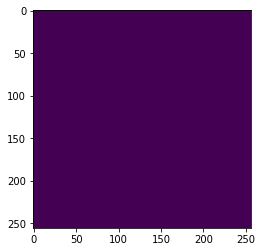

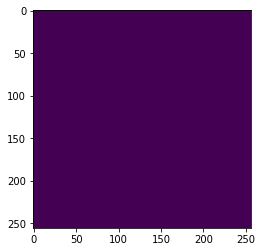

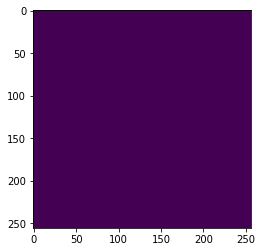

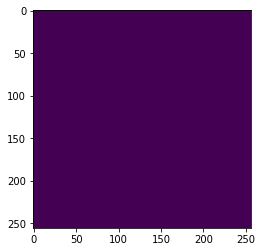

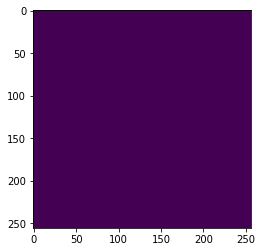

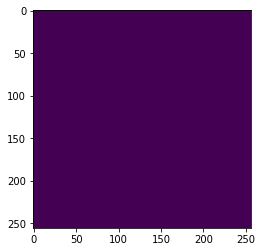

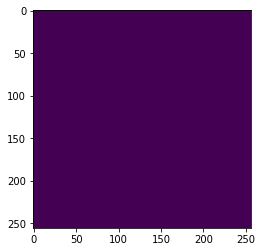

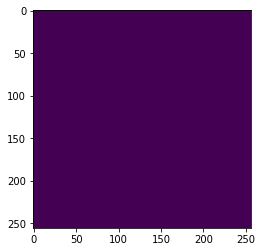

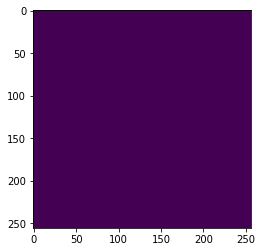

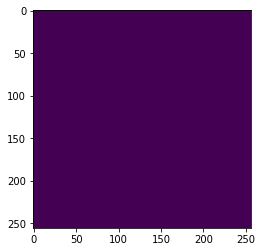

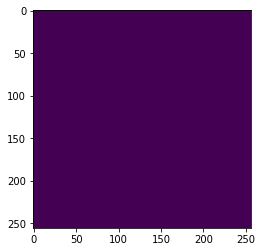

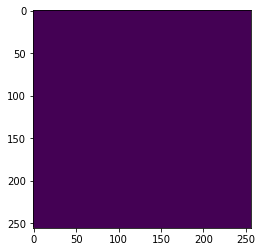

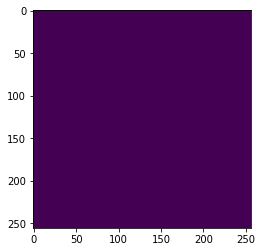

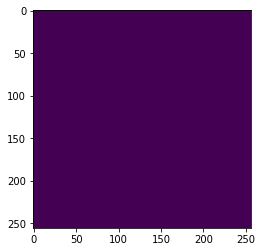

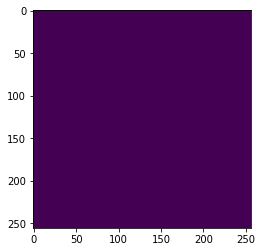

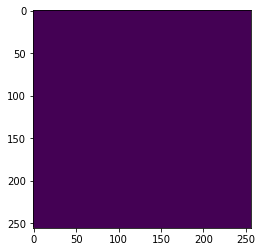

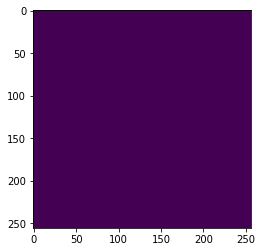

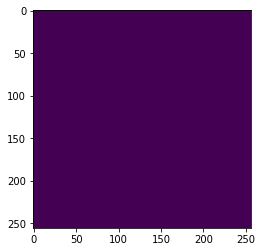

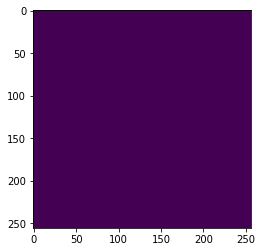

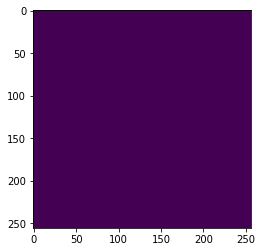

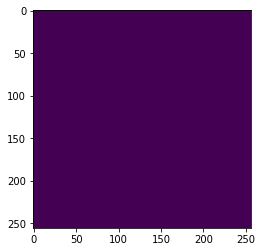

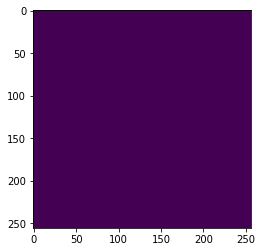

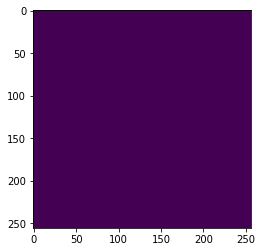

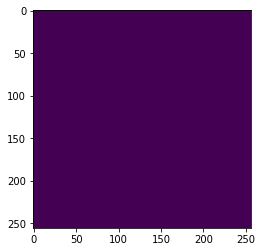

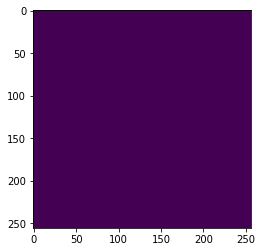

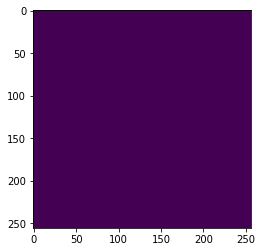

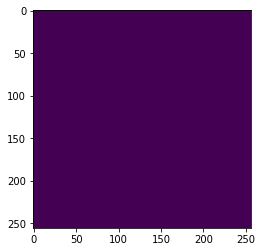

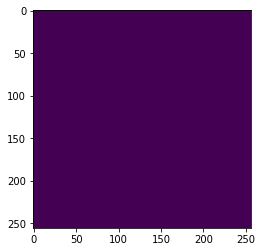

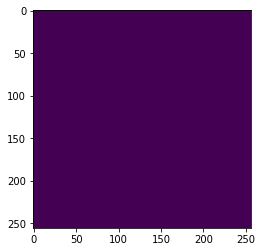

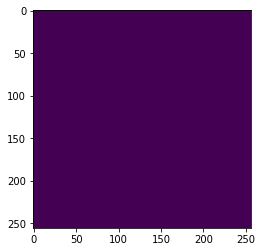

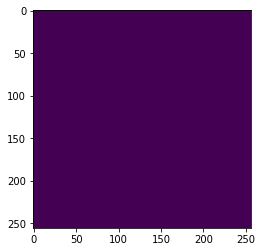

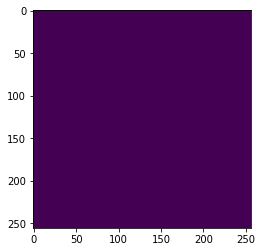

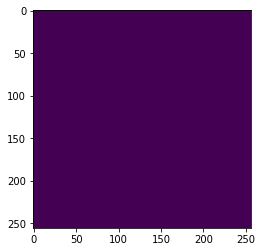

In [17]:
for i in range(33):
    r0 = results[i].reshape(256,256)
    plt.imshow(r0)
    plt.show()


In [24]:
import zipfile
source = './dataset1/res1'
target_name = './dataset1/dataset1.zip'
fzip = zipfile.ZipFile(target_name, 'w', zipfile.ZIP_DEFLATED)
flist = os.listdir(source)
#basename = os.path.basename(source)
for name in flist:
    fpath = os.path.join(source, name)
    #arcname = os.path.join(basename, name)
    #写入要压缩文件，并添加归档文件名称
    fzip.write(fpath)
#关闭
fzip.close()


In [20]:
if os.system(zip_command) == 0:
    print ('Successful backup to', target)
else:
    print ('Backup FAILED \
    !!!use sudo in the terminal')

Backup FAILED     !!!use sudo in the terminal
